### Olist Table structure (original)


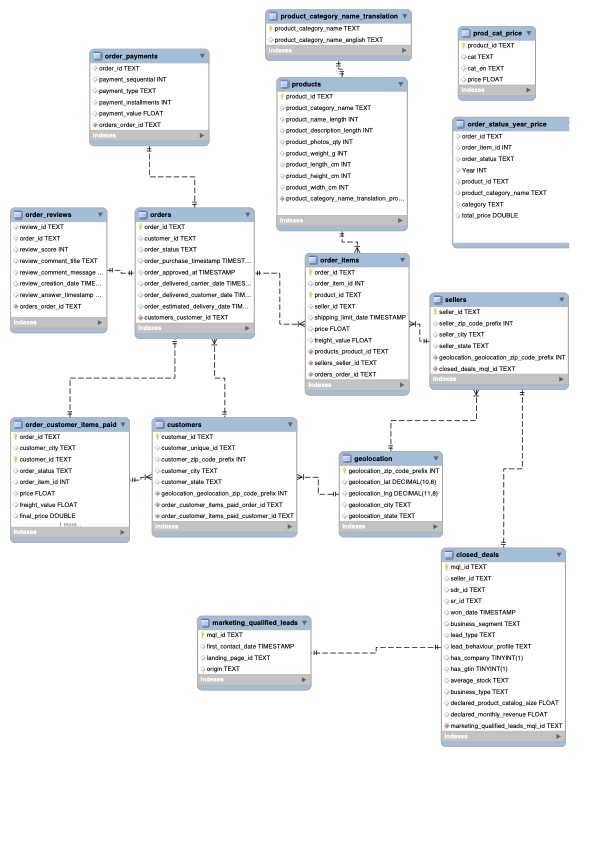

----

In [23]:
import pandas as pd
import getpass
import sqlalchemy as sa
import pymysql





# Importing SQL- analysing & cleaning data using pandas

In [24]:

driver = 'mysql+pymysql'
user = 'root'
password = getpass.getpass(prompt='Your password:'"")
ip = '127.0.0.1'

connection_string = f'{driver}://{user}:{password}@{ip}'
    
db_connection = sa.create_engine(connection_string)

insp = sa.inspect(db_connection)
db_list = insp.get_schema_names()


Your password:········


In [25]:
# to push back to workbench:

#df.to_sql(con=db_connection, name='table_name_for_df', if_exists='replace', flavor='mysql')




## Check Olist tables concerning missing or misleading data

In [49]:
query = "SELECT * FROM olist.closed_deals"
closed_deals = pd.read_sql_query(query, db_connection)

In [50]:
##cleaning

def closed_deals_clean(closed_deals):
    #delete (no value added)
    closed_deals = closed_deals.drop(columns=['sdr_id'])
    closed_deals = closed_deals.drop(columns=['sr_id'])
    #delete (too many nulls)
    closed_deals = closed_deals.drop(columns=['lead_behaviour_profile'])
    closed_deals = closed_deals.drop(columns=['has_company'])
    closed_deals = closed_deals.drop(columns=['has_gtin'])
    closed_deals = closed_deals.drop(columns=['average_stock'])
    closed_deals = closed_deals.drop(columns=['declared_product_catalog_size'])
    #delete (too manny values = 0)
    closed_deals = closed_deals.drop(columns=['declared_monthly_revenue'])
    return closed_deals

closed_deals = closed_deals_clean(closed_deals)

closed_deals.isnull().sum()

##interesting to analyse
# time to close deal
# closed_deals per time (quarter/year)
# percentage buisness_segment and business_type


mql_id               0
seller_id            0
won_date             0
business_segment     1
lead_type            6
business_type       10
dtype: int64

In [55]:
#to push back to workbench:

closed_deals.to_sql(con=db_connection, schema='olist', name='closed_deals', if_exists='replace')

-----

In [13]:
query = "SELECT * FROM olist.marketing_qualified_leads"
marketing_qualified_leads = pd.read_sql_query(query, db_connection)
marketing_qualified_leads.isnull().sum()



## interesting (related to closed_deals)
# top 10 landing_page
# origin (also by time to close)

mql_id                 0
first_contact_date     0
landing_page_id        0
origin                60
dtype: int64

In [58]:
##cleaning
# null cells in origin into "unknown"
marketing_qualified_leads['origin'] = marketing_qualified_leads["origin"].fillna(value = 'unknown')
#marketing_qualified_leads.isnull().sum()

mql_id                0
first_contact_date    0
landing_page_id       0
origin                0
dtype: int64

In [59]:
#to push back to workbench:

marketing_qualified_leads.to_sql(con=db_connection, schema='olist', name='marketing_qualified_leads', if_exists='replace')

-----

In [62]:
query = "SELECT * FROM olist.`sellers`"
sellers = pd.read_sql_query(query, db_connection)
sellers.isnull().sum()


## interesting
#seller city
#seller state 

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [67]:
##cleaning
#seller_city one has a number = rio de janeiro 04482255
sellers = sellers.replace(to_replace='04482255', value = 'rio de janeiro')
#tbd :seller state = full name

In [68]:
#to push back to workbench:

sellers.to_sql(con=db_connection, schema='olist', name='sellers', if_exists='replace')

-----

In [75]:
query = "SELECT * FROM olist.orders"
orders = pd.read_sql_query(query, db_connection)
orders.isnull().sum()


##interesting
# percentage order status 
# actual vs esimated delivery date (only orders who have a order_delivered_customer_date)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [76]:
##cleaning
#bucketing "processing & approved, invoiced"  as these orders have not been processed correctly: new name "unprocessed"; rename "shipped" "lost_during_delivery"

orders.order_status[orders.order_status.isin(["processing","invoiced", "approved"])] = "unprocessed"
orders.order_status[orders.order_status.isin(["shipped"])] = "lost_during_delivery"
orders.order_status.unique()

<ipython-input-76-848ae4a943b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders.order_status[orders.order_status.isin(["processing","invoiced", "approved"])] = "unprocessed"
<ipython-input-76-848ae4a943b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders.order_status[orders.order_status.isin(["shipped"])] = "lost_during_delivery"


array(['delivered', 'unprocessed', 'lost_during_delivery', 'unavailable',
       'canceled', 'created'], dtype=object)

In [77]:
#to push back to workbench:

orders.to_sql(con=db_connection, schema='olist', name='orders', if_exists='replace')

-----

In [15]:
query = "SELECT * FROM olist.order_items"
order_items = pd.read_sql_query(query, db_connection)
order_items.isnull().sum()

## findings
# freight_value & price & final_price are the prices for the customer (and is the same as in other tables)
# order_item_id has  21 uniques -->  shows how many items are included in one order shipped out to the customer
# shipping_limit_date = latest time when the seller has to give the product to the carrier for delivery

##interesting
#which seller violate the shipping_limit_date (shipping_date_limit<order_delivered_carrier_date)

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

-----

In [112]:
query = "SELECT * FROM olist.order_payments"
order_payments = pd.read_sql_query(query, db_connection)
order_payments.isnull().sum()


## Interesting
#percentage of payment_type per month /year (reference order_delivered_customer_date)
#payment_installments: average payment_installments, zip_code analysis, category analysis

index                   0
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [114]:
## cleanining
#payment_type = delete rows where type = 'not_defined' as payment value of these three order = 0€
#deleted in sql

#'''delete from olist.order_payments where order_id in ('4637ca194b6387e2d538dc89b124b0ee','00b1cb0320190ca0daa2c88b35206009','c8c528189310eaa44a745b8d9d26908b')'''

#payment_sequential = no clear added value
order_payments = order_payments.drop(columns=['payment_sequential'])

In [115]:
#to push back to workbench:

order_payments.to_sql(con=db_connection, schema='olist', name='order_payments', if_exists='replace')

-----

In [7]:
query = "SELECT * FROM olist.customers"
customers = pd.read_sql_query(query, db_connection)
customers.isnull().sum()

##cleaning
#tbd customer state = full name

## interesting
#customer city
#customer state 

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

-----

In [14]:
query = "SELECT * FROM olist.`order_customer_items_paid`"
order_customer_items_paid = pd.read_sql_query(query, db_connection)
order_customer_items_paid.isnull().sum()

##
#how many delivered orders haven't been paid yet (compare with order_ids in orders where status is 'delivered'):
 ''' No one:
SELECT *
from orders
Left join `order_customer_items_paid`
using (order_id)
where order_customer_items_paid.order_id is null and orders.order_status in ('delivered')
'''

##Interesting
#show percentage odrder_status (if order_status = "shipping" / "lost_during_delivery" --> order paid but not received)

order_id         0
customer_city    0
customer_id      0
order_status     0
order_item_id    0
price            0
freight_value    0
final_price      0
dtype: int64

----

In [17]:
query = "SELECT * FROM olist.order_reviews"
order_reviews = pd.read_sql_query(query, db_connection)
order_reviews.isnull().sum()

## interesting
# review_score
# top 10 seller score / low 10 seller score compare to their revenue per month/year 
# review answer velocity over time(month/year) (calculated review_answer_timestamp-review_creation_date)
# from which region come the most reviews / also by good and bad score

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58245
review_creation_date           0
review_answer_timestamp        0
dtype: int64

-----

In [19]:
query = "SELECT * FROM olist.`order_status_year_price`"
order_status_year_price = pd.read_sql_query(query, db_connection)
order_status_year_price.isnull().sum()
##findings
#only delivered 
# Year referres to the order_purchase_timestamp from orders
# no additional information to order_customer_items_paid

##cleaning
#we will drop this table --> we will drop it in sql: drop table `order_status_year_price`




order_id                 0
order_item_id            0
order_status             0
Year                     0
product_id               0
product_category_name    0
category                 0
total_price              0
dtype: int64

-----

In [171]:
query = "SELECT * FROM olist.`products`"
products = pd.read_sql_query(query, db_connection)
products.isnull().sum()


##interesting
# which seller haven't provided all of the necessary information 



index                           0
product_id                      0
product_category_name         610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                6
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [172]:
##cleaning
# drop null values as they are won't give any value in answering the most bought categories
products =products.dropna()

#change product_catgeory_name to english

def change_name(x):
    if not x == x:
        return x
    else:
        category = {"beleza_saude": "health_beauty",
        "informatica_acessorios":"computers_accessories",
        "automotivo":"auto",
        "cama_mesa_banho":"bed_bath_table",
        "moveis_decoracao":"furniture_decor",
        "esporte_lazer":"sports_leisure",
        "perfumaria":"perfumery",
        "utilidades_domesticas":"housewares",
        "telefonia":"telephony",
        "relogios_presentes":"watches_gifts",
        "alimentos_bebidas":"food_drink",
        "bebes":"baby",
        "papelaria":"stationery",
        "tablets_impressao_imagem":"tablets_printing_image",
        "brinquedos":"toys",
        "telefonia_fixa":"fixed_telephony",
        "ferramentas_jardim":"garden_tools",
        "fashion_bolsas_e_acessorios":"fashion_bags_accessories",
        "eletroportateis":"small_appliances",
        "consoles_games":"consoles_games",
        "audio":"audio",
        "fashion_calcados":"fashion_shoes",
        "cool_stuff":"cool_stuff",
        "malas_acessorios":"luggage_accessories",
        "climatizacao":"air_conditioning",
        "construcao_ferramentas_construcao":"construction_tools_construction",
        "moveis_cozinha_area_de_servico_jantar_e_jardim":"kitchen_dining_laundry_garden_furniture",
        "construcao_ferramentas_jardim":"costruction_tools_garden",
        "fashion_roupa_masculina":"fashion_male_clothing",
        "pet_shop":"pet_shop",
        "moveis_escritorio":"office_furniture",
        "market_place":"market_place",
        "eletronicos":"electronics",
        "eletrodomesticos":"home_appliances",
        "artigos_de_festas":"party_supplies",
        "casa_conforto":"home_confort",
        "construcao_ferramentas_ferramentas":"costruction_tools_tools",
        "agro_industria_e_comercio":"agro_industry_and_commerce",
        "moveis_colchao_e_estofado":"furniture_mattress_and_upholstery",
        "livros_tecnicos":"books_technical",
        "casa_construcao":"home_construction",
        "instrumentos_musicais":"musical_instruments",
        "moveis_sala":"furniture_living_room",
        "construcao_ferramentas_iluminacao":"construction_tools_lights",
        "industria_comercio_e_negocios":"industry_commerce_and_business",
        "alimentos":"food",
        "artes":"art",
        "moveis_quarto":"furniture_bedroom",
        "livros_interesse_geral":"books_general_interest",
        "construcao_ferramentas_seguranca":"construction_tools_safety",
        "fashion_underwear_e_moda_praia":"fashion_underwear_beach",
        "fashion_esporte":"fashion_sport",
        "sinalizacao_e_seguranca":"signaling_and_security",
        "pcs":"computers",
        "artigos_de_natal":"christmas_supplies",
        "fashion_roupa_feminina":"fashio_female_clothing",
        "eletrodomesticos_2":"home_appliances_2",
        "livros_importados":"books_imported",
        "bebidas":"drinks",
        "cine_foto":"cine_photo",
        "la_cuisine":"la_cuisine",
        "musica":"music",
        "casa_conforto_2":"home_comfort_2",
        "portateis_casa_forno_e_cafe":"small_appliances_home_oven_and_coffee",
        "cds_dvds_musicais":"cds_dvds_musicals",
        "dvds_blu_ray":"dvds_blu_ray",
        "flores":"flowers",
        "artes_e_artesanato":"arts_and_craftmanship",
        "fraldas_higiene":"diapers_and_hygiene",
        "fashion_roupa_infanto_juvenil":"fashion_childrens_clothes",
        "seguros_e_servicos":"security_and_services",
         "pc_gamer":"pc_gamer", 
         "portateis_cozinha_e_preparadores_de_alimentos":"kitchen_appliance"}

        return category[x]
    


In [173]:
products["product_category_name"] = products["product_category_name"].apply(change_name)


In [174]:
products["product_category_name"].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
       'home_app

In [175]:
#to push back to workbench:

products.to_sql(con=db_connection, schema='olist', name='products', if_exists='replace')

-----

In [116]:
query = "SELECT * FROM olist.`product_category_name_translation`"
product_category_name_translation = pd.read_sql_query(query, db_connection)
product_category_name_translation.isnull().sum()

##cleaning
# just needed to translate we will drop table in sql



product_category_name            0
product_category_name_english    0
dtype: int64

In [12]:
query = "SELECT * FROM olist.geolocation"
geolocation = pd.read_sql_query(query, db_connection)
geolocation.isnull().sum()

# we don't need this table as we are using tableau and it can create lattitude itself with the city information
#we will drop table in sql

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64